# 1. SED-Lab training notebook

## 1.1 Define training parameters

Setup parameters for the machine learning.
<br>See [model.md](../src/model/model.md) for more information about neural network architectures

In [31]:
# Audio sample parameters
AUDIO_CHUNK = 0.4  # sample length in seconds
SLICE_AUDIO = False # Trim/Pad your audio samples to the "AUDIO_CHUNK" length?
DATA_RANGE = 255  # 1 or 255 - does the NN take values 0-1 or 0-255?
NUM_CHANNELS = 1  # Typically 1 for mono audio
SAMPLE_RATE = 44100  # Sample rate in Hz
Test = False # Test mode - use only 10 samples to finetune training features


# Audio Feature parameters:
""" Prefered settings:
stft - NFFT = 256, HOP_LENGTH = 128, NFFT = 2048,
mfcc - N_MFCC = 40, HOP_LENGTH = 512
mel - N_MELS = 256, HOP_LENGTH = 512
"""

MAIN_FEATURE = 'mel'  # 'mfcc' or 'mel' or 'stft'
N_MELS = 128  # Number of Mel bands (applicable only for 'mel')
NFFT = 2048  # FFT window size for 'stft'
HOP_LENGTH = 128  # Number of samples between successive frames (HOP<NFFT -> frame overlap)
N_MFCC = 40  # Number of MFCC coefficients (applicable only for 'mfcc')
FMAX = SAMPLE_RATE // 2  # Maximum frequency, typically Nyquist frequency
N_FRAMES = round((SAMPLE_RATE * AUDIO_CHUNK) / HOP_LENGTH) # Calculate number of frames
SCALER = "minmax"  # 'standard' or 'minmax' or 'robust' or 'maxabs' or None' - data normalization method

# Training settings
EPOCHS = 25
BATCH_SIZE = 32     # 8 - 64
LEARNING_RATE = 1e-3    # 1e-3 is a good starting point, when too unstable try 1e-4
AUGMENTATION = True     # Do you want to use data augmentation in training?    

# Model settings
MODEL_FORMAT = 'keras'  # 'h5', 'keras', 'tf', 'tflite' - format of the output model
LITE_VERSION = False  # Do you want to produce TF-lite version of the model?

MODEL_ARCH = "SmallerVGGNet"    # see Training Settings in Readme
MODEL_TYPE = "default"       # see Training Settings in Readme
NEW_MODEL_NAME = '19_PNY_299'       #  USE YOUR CUSTIOM NAME TO NAME ALL YOUR RESULTS FROM THIS TRAINING SESSION!
LABELS = []         # Do not change

# Do not change following
# ***  Input shape *** #
if MAIN_FEATURE == 'mfcc':
    INPUT_SHAPE = (N_FRAMES, N_MFCC, NUM_CHANNELS)
elif MAIN_FEATURE == 'mel':
    INPUT_SHAPE = (N_FRAMES, N_MELS, NUM_CHANNELS)
elif MAIN_FEATURE == 'stft':
    INPUT_SHAPE = (N_FRAMES, NFFT // 2 + 1, NUM_CHANNELS)

print('Input shape:', INPUT_SHAPE)

Input shape: (138, 128, 1)


## 1.2 Load Dependencies
You need to select the virtual environment you created during installation step as a kernel in this Jupyter notebook and have all required packages installed.

In [32]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from src.audio_processor import AudioProcessor
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import joblib
import random
from src.model.model import Deep_NN
from IPython.display import Audio, display


GPU usage is optional and this step can be skipped.

<i>Do you have Nvidia GPU ? If so you should see the following cell return something like GPU:0 ... If it returns [ ], it means no GPU was found and you need to install CUDA toolkit to utilize your GPU during training. 
<br>Windows native supports GPU training only until `tensorflow<2.11`
<br>See: https://www.tensorflow.org/install/pip#windows-native</i>

In [33]:
print(tf.config.list_physical_devices('GPU'))

[]


## 2.1 Define Paths to Files
In here we setup all the paths and directories we will need during training to stay organised.
<br>All outputs that are produced by this notebook have setup unified naming conventions and storeplaces.

In [34]:
current_dir = os.getcwd()
ROOT_DIR = os.path.dirname(current_dir) # one level up directory

# Define paths relative to the root directory
DATASET_DIR = os.path.join(ROOT_DIR, 'DATA', 'DATASET')
DATA_DIR = os.path.join(ROOT_DIR, 'DATA')
MODEL_DIR = os.path.join(ROOT_DIR, 'MODEL')
TEST_DIR = os.path.join(ROOT_DIR, 'DATA', 'TEST_DATA')
PLOTS_DIR = os.path.join(ROOT_DIR, 'MODEL', 'PLOTS')
CONFIG_DIR = os.path.join(ROOT_DIR, 'config')

METADATA = os.path.join(CONFIG_DIR, 'metadata.csv')

MODEL_PATH = os.path.join(MODEL_DIR, f"{NEW_MODEL_NAME}-MODEL-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}")
LITE_MODEL_PATH = os.path.join(MODEL_DIR, f"{NEW_MODEL_NAME}-LiteMODEL-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.tflite")
LABELER_PATH = os.path.join(MODEL_DIR, f"{NEW_MODEL_NAME}-ENCODER-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, f"{NEW_MODEL_NAME}-SCALER-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.joblib")
CONFIG_PATH = os.path.join(CONFIG_DIR, f"{NEW_MODEL_NAME}-CONFIG-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.json")

# create folders if they don't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(CONFIG_DIR):
    os.makedirs(CONFIG_DIR)

# 2. Processing the dataset

- Put recorded dataset into "DATASET" folder.
- Recorded dataset shall be in format, where each audio class has its separate folder.
- Folders are named as wanted classification labels.

You can use "Dataset Recorder" tool to produce such dataset. 
<br>(https://github.com/Teapack1/Audio-Dataset-Recorder-Tools)

Example command to produce dataset:
<br>`python dr.py --classes car_horn baby_cry glass_break male_scream --duration 0.5 --num_samples 100 --playback --treshold 0.25 --sample_rate 44100`

## 2.1 Initialize the dataset
List basic info about the dataset, that its present, it has some classes and initialize our processing class bellow.

In [35]:
dataset_files = os.listdir(DATASET_DIR)
model_files = os.listdir(MODEL_DIR)
test_files = os.listdir(TEST_DIR)

print("Files in 'DATASET' folder:")
print(dataset_files)
LABELS = dataset_files

print("Files in 'MODEL' folder:")
print(model_files)

print("Files in 'TEST' folder:")
print(test_files)

Files in 'DATASET' folder:
['-cheers', '-cuttlery', '-dishesCuttlery', '-listen_not', '-ncheer3', '-not', '-_listen_not', 'whiskey', 'wine', '_whiskey', '_wine']
Files in 'MODEL' folder:
['19_PNY_299-CONFIG-SmallerVGGNet-default-mel.json', '19_PNY_299-CONFIG-SmallerVGGNet-default-mfcc.json', '19_PNY_299-CONFIG-SmallerVGGNet-default-stft.json', '19_PNY_299-ENCODER-SmallerVGGNet-default-mel.joblib', '19_PNY_299-ENCODER-SmallerVGGNet-default-mfcc.joblib', '19_PNY_299-ENCODER-SmallerVGGNet-default-stft.joblib', '19_PNY_299-MODEL-SmallerVGGNet-default-mel', '19_PNY_299-MODEL-SmallerVGGNet-default-mel.keras', '19_PNY_299-MODEL-SmallerVGGNet-default-mfcc', '19_PNY_299-MODEL-SmallerVGGNet-default-mfcc.keras', '19_PNY_299-MODEL-SmallerVGGNet-default-stft', '19_PNY_299-MODEL-SmallerVGGNet-default-stft.keras', '19_PNY_299-SCALER-SmallerVGGNet-default-mel.joblib', '19_PNY_299-SCALER-SmallerVGGNet-default-mfcc.joblib', '19_PNY_299-SCALER-SmallerVGGNet-default-stft.joblib', 'PLOTS']
Files in 'TEST' 

Setup AudioProcessor class instance with parameters we set in the beginning, to help us to process raw audio files into image-from features to final machine learning tensors.

In [36]:
audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, 
                                 n_mels = N_MELS,
                                 n_mfcc=N_MFCC, 
                                 fmax = FMAX,
                                 n_fft = NFFT,
                                 hop_length = HOP_LENGTH, 
                                 audio_chunk = AUDIO_CHUNK,
                                 slice_audio = SLICE_AUDIO,
                                 data_range=DATA_RANGE,
                                 main_feature=MAIN_FEATURE,
                                 use_delta=False,
                                 scaler_type=SCALER
                                 )
                

## 2.2 Label Encoding

Supervised machine learning relies on labeled datasets for training. Although we have sorted our `.wav` files into named folders corresponding to their labels, algorithms do not understand human language. Therefore, we need to encode all the labels into numerical representations.

One approach is to use simple numbers like `0, 1, 2, etc.`, to represent individual labels. However, we use a method called **One-Hot Encoding**, which encodes each label as an array with a length equal to the total number of labels. In this array, the label is represented by a `1` at the index corresponding to the label's position, and `0`s elsewhere. For example, `[1, 0, 0, 0, 0]` represents the first label.

This method helps eliminate bias that can be introduced by representing labels with incremental numbers. Incremental numbering might create an unintended relationship between higher numbers and certain features, potentially affecting the training process. **One-Hot Encoding** avoids this by treating all labels as equally independent, which can lead to more accurate and unbiased model training.


In [37]:
def process_label(label):
    if label.startswith("-"):
        return "not"
    return label.replace("*", "").replace("_", "")


def encoder_fn(dataset_dir, labeler_dir, encoder, dump=False):
    classes = []
    for class_name in os.listdir(dataset_dir):
        processed_label = process_label(class_name)
        if processed_label not in classes:
            classes.append(processed_label)
    
    classes.sort()
    classes = np.array(classes).reshape(-1, 1)
    print(classes)
    try:
        encoder.fit(classes)
    except IndexError:
        print("No classes found in dataset folder")
    if dump:
        joblib.dump(encoder, labeler_dir)


def idx2label(idx, encoder):
    idx_reshaped = np.array(idx).reshape(1, -1)
    return encoder.inverse_transform(idx_reshaped)[0][0]


def label2idx(label, encoder):
    processed_label = process_label(label)
    processed_label = np.array(processed_label).reshape(-1, 1)
    return encoder.transform(processed_label).toarray()[0]

In [38]:
oh_encoder = OneHotEncoder()

encoder_fn(dataset_dir=DATASET_DIR, labeler_dir=LABELER_PATH, encoder=oh_encoder)

[['not']
 ['whiskey']
 ['wine']]


## 2.3 Exploratory Data Analysis

Exploratory Data Analysis (EDA) helps identify potential issues with the data, such as missing values, outliers, and imbalances among classes, which can significantly impact the performance of the machine learning model.



### Produce metadata dataframe

In [39]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATASET_DIR):
    for i, file in enumerate(files):
        if Test and i > 10:
            break
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label, oh_encoder)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = audio_processor.read_file_properties(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processing label: {label}, {i}th file named: {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Skipped 0 file. listen_cheers1642541907.4671087.png
Processing label: -cheers, 1th file named: listen_cheers1642541907.4671087.wav
Skipped 2 file. listen_cheers1642542677.3064995.png
Processing label: -cheers, 3th file named: listen_cheers1642542677.3064995.wav
Skipped 4 file. listen_cheers1642543563.733368.png
Processing label: -cheers, 5th file named: listen_cheers1642543563.733368.wav
Skipped 6 file. listen_cheers1642545497.4271278.png
Processing label: -cheers, 7th file named: listen_cheers1642545497.4271278.wav
Skipped 8 file. listen_cheers1642545497.7952142.png
Processing label: -cheers, 9th file named: listen_cheers1642545497.7952142.wav
Skipped 10 file. listen_cheers1642545498.5902672.png
Processing label: -cheers, 11th file named: listen_cheers1642545498.5902672.wav
Skipped 12 file. listen_ding1550414188.5720596.png
Processing label: -cheers, 13th file named: listen_ding1550414188.5720596.wav
Skipped 14 file. listen_ding1550414510.4624586.png
Processing label: -cheers, 15th fi

### Observe the data

In [40]:
metadata.head()

filename    label  \
0  e:\User\majoron\Python\project\Audio-Classify-...  -cheers   
1  e:\User\majoron\Python\project\Audio-Classify-...  -cheers   
2  e:\User\majoron\Python\project\Audio-Classify-...  -cheers   
3  e:\User\majoron\Python\project\Audio-Classify-...  -cheers   
4  e:\User\majoron\Python\project\Audio-Classify-...  -cheers   

             class  num_channels  sample_rate  bit_depth   avg_rms  \
0  [1.0, 0.0, 0.0]             1        44100         16  0.006526   
1  [1.0, 0.0, 0.0]             1        44100         16  0.004481   
2  [1.0, 0.0, 0.0]             1        44100         16  0.004602   
3  [1.0, 0.0, 0.0]             1        44100         16  0.004556   
4  [1.0, 0.0, 0.0]             1        44100         16  0.004673   

   length_in_seconds  length_in_frames  
0           0.397642             17536  
1           0.397642             17536  
2           0.397642             17536  
3           0.397642             17536  
4           0.397642             17536

### class balance

In [41]:
print(metadata["label"].value_counts())

label
_whiskey           2400
_wine              2400
wine               1632
whiskey            1519
-_listen_not       1250
-listen_not        1024
-cheers             490
-dishesCuttlery     400
-cuttlery           327
-ncheer3            150
-not                134
Name: count, dtype: int64


### plot class waveforms

e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-cheers\listen_cheers1642541907.4671087.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-cuttlery\cutlery1_0001.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-dishesCuttlery\dishescutlery1_0001.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-listen_not\listen_whiskey_1718279206.9252808.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-ncheer3\ncheer3_0001.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-not\not_0001.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-_listen_not\listen_not_mTotalNoise_0001.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\whiskey\listen_not_1718027020.9033947.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\wine\dilnaWine_0002.wav
e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\_whiskey\whiskey_bimNoise_19_0001.wav


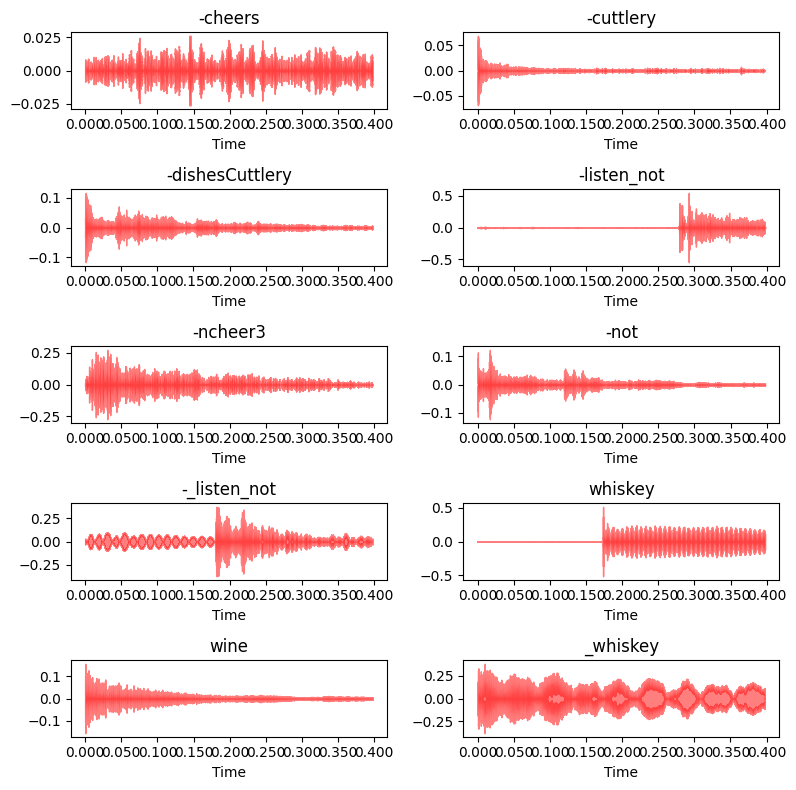

In [44]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels[:10]):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name), sr=SAMPLE_RATE, mono=False)
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show() 

In [45]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
print(metadata.avg_rms.describe())


Channels: 
num_channels
1    1.0
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    1.0
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count    11726.000000
mean     17544.669197
std          7.408621
min      17536.000000
25%      17536.000000
50%      17551.000000
75%      17551.000000
max      17551.000000
Name: length_in_frames, dtype: float64


Length (s): 
count    11726.000000
mean         0.397838
std          0.000168
min          0.397642
25%          0.397642
50%          0.397982
75%          0.397982
max          0.397982
Name: length_in_seconds, dtype: float64
count    11726.000000
mean         0.047570
std          0.045575
min          0.000465
25%          0.020535
50%          0.036299
75%          0.060063
max          0.890025
Name: avg_rms, dtype: float64


## 2.4 Audio Feature Preprocessing:

### Test Main Feature
(Spectrogram , Mel Spectrogram, MFCC)


audio_file shape (17536,) - (frames, channels)
audio_file sample rate 44100 Hz
Spectrogram shape (138, 128) - (frames/time, mels/frequency,)
spectrogram min: 0 spectrogram max: 255, average: 138.2823822463768
spectrogram dtype: uint8
audio dtype: float32 - bit depth


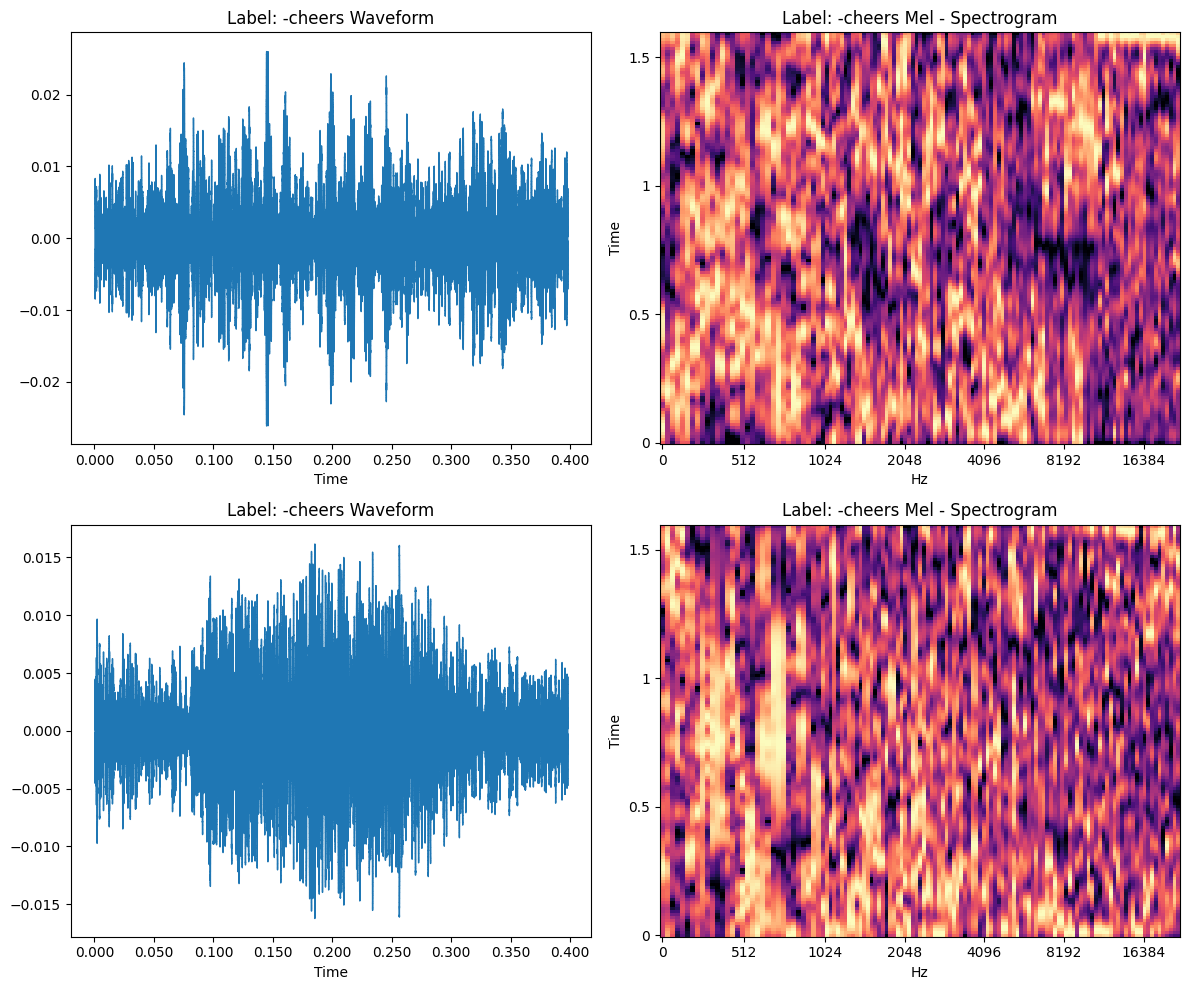

In [46]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
)

test_scaler = MinMaxScaler(feature_range=(0, 1))
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
if Test:
    rows = metadata.iloc[[0, 2]]
else:
    rows = metadata.iloc[[1800, 6200]]

#rows = metadata.sample(2)
slice_length = AUDIO_CHUNK
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 5))

for i, row in rows.iterrows():
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"], sr=SAMPLE_RATE)
    if SLICE_AUDIO: 
        print(slice)
        sample_length = slice_length * SAMPLE_RATE

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)

##### MFCC #####

    if MAIN_FEATURE == 'mfcc':
        # Generate the MFCC
        spectrogram = audio_processor.extract_mfcc(y=audio_file)
        spectrogram = spectrogram.T

        test_scaler.fit(spectrogram)
        spectrogram = test_scaler.transform(spectrogram)
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        
        if DATA_RANGE == 255:
            spectrogram = spectrogram * 255.0
            spectrogram = spectrogram.astype(np.uint8)
        elif DATA_RANGE == 1:
            spectrogram = (spectrogram * 2) - 1

                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} MFCC")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1

##### MEL SPECTROGRAM #####

    elif MAIN_FEATURE == 'mel':
        # Generate the mel spectrogram
        spectrogram = librosa.feature.melspectrogram(
            y=audio_file,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=NFFT,
            hop_length=HOP_LENGTH,
        )
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        spectrogram = spectrogram.T

        test_scaler.fit(spectrogram)
        spectrogram = test_scaler.transform(spectrogram)
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        
        if DATA_RANGE == 255:
            spectrogram = spectrogram * 255.0
            spectrogram = spectrogram.astype(np.uint8)
        elif DATA_RANGE == 1:
            spectrogram = (spectrogram * 2) - 1

                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} Mel - Spectrogram")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1

##### STFT #####

    elif MAIN_FEATURE == 'stft':
        # Generate the mel spectrogram
        spectrogram = librosa.stft(y=audio_file, n_fft=NFFT, hop_length=HOP_LENGTH)
        spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        spectrogram = spectrogram.T

        test_scaler.fit(spectrogram)
        spectrogram = test_scaler.transform(spectrogram)
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        
        if DATA_RANGE == 255:
            spectrogram = spectrogram * 255.0
            spectrogram = spectrogram.astype(np.uint8)
        elif DATA_RANGE == 1:
            spectrogram = (spectrogram * 2) - 1

                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1

    # Play the audio
    display(Audio(audio_file, rate=SAMPLE_RATE))


print(f"audio_file shape {audio_file.shape} - (frames, channels)")
print(f"audio_file sample rate {SAMPLE_RATE} Hz")
print(f"Spectrogram shape {spectrogram.shape} - (frames/time, mels/frequency,)")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype} - bit depth")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

## 3 Prepare Dataset

## 3.1 Extract features and labels into dataframe

In [47]:
# Preprocessing function

def extract_features(row):
    
    class_label = row["class"]
    
    audio_file,_ = librosa.load(row["filename"], sr=SAMPLE_RATE)

    spectrogram = audio_processor(
        data = audio_file)
    
    shape = spectrogram.shape

    return spectrogram, class_label, shape

In [48]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    spectrogram, class_label, shape = extract_features(row)
    features.append((spectrogram, class_label, shape))
    print(f"Processed {index} file. {row['filename']} - Shape: {shape}")


# Check for consistent shapes
shapes = [f[2] for f in features]
print(f"Shapes of extracted features: {shapes}")

# Optionally, pad or truncate spectrograms to ensure uniform shape
max_frames = max([shape[0] for shape in shapes])
max_bins = max([shape[1] for shape in shapes])

def pad_spectrogram(spectrogram, max_frames, max_bins):
    padded_spectrogram = np.zeros((max_frames, max_bins))
    padded_spectrogram[:spectrogram.shape[0], :spectrogram.shape[1]] = spectrogram
    return padded_spectrogram


features = [(pad_spectrogram(f[0], max_frames, max_bins), f[1], (max_frames, max_bins)) for f in features]


dataset_df = pd.DataFrame(features, columns=["features", "class_label", "shape"])
print('Finished feature extraction from', len(dataset_df), 'files')

# Set N_FRAMES and INPUT_SHAPE
N_FRAMES = max_frames
INPUT_SHAPE = (N_FRAMES, max_bins, NUM_CHANNELS)
print(f"Number of frames: {N_FRAMES}")
print(f"Input shape: {INPUT_SHAPE}")

Error: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Scaler will be fitted later on the raw dataset...
Processed 0 file. e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-cheers\listen_cheers1642541907.4671087.wav - Shape: (138, 128)
Error: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Scaler will be fitted later on the raw dataset...
Processed 1 file. e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-cheers\listen_cheers1642542677.3064995.wav - Shape: (138, 128)
Error: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Scaler will be fitted later on the raw dataset...
Processed 2 file. e:\User\majoron\Python\project\Audio-Classify-2\DATA\DATASET\-cheers\listen_cheers1642543563.733368.wav - Shape: (138, 128)
Error: This MinMaxScaler instance is not fitted yet. Call 'fit

### Our feature data stats:

In [49]:
dataset_df.head()

features      class_label  \
0  [[-24.205934524536133, -29.823209762573242, -3...  [1.0, 0.0, 0.0]   
1  [[-34.8756217956543, -27.589792251586914, -28....  [1.0, 0.0, 0.0]   
2  [[-31.487075805664062, -30.75761604309082, -31...  [1.0, 0.0, 0.0]   
3  [[-17.55426597595215, -23.193620681762695, -24...  [1.0, 0.0, 0.0]   
4  [[-8.997772216796875, -16.5283260345459, -28.9...  [1.0, 0.0, 0.0]   

        shape  
0  (138, 128)  
1  (138, 128)  
2  (138, 128)  
3  (138, 128)  
4  (138, 128)

In [50]:
print(f"Dataset shape: {dataset_df['shape'].value_counts()}")
print(f"Data values Min: {dataset_df['features'].apply(lambda x: x.min()).min()}, Max: {dataset_df['features'].apply(lambda x: x.max()).max()}, dtype: {dataset_df['features'].apply(lambda x: x.dtype).unique()} \nAverage: {dataset_df['features'].apply(lambda x: x.mean()).mean()}, Median: {dataset_df['features'].apply(lambda x: x.mean()).median()}")
print(f"Number of time frames N_FRAMES: {N_FRAMES}")
dataset_df_scaled = dataset_df.copy()

Dataset shape: shape
(138, 128)    11726
Name: count, dtype: int64
Data values Min: -80.0, Max: 3.814697265625e-06, dtype: [dtype('float64')] 
Average: -44.896442564970606, Median: -45.14912491027212
Number of time frames N_FRAMES: 138


### 3.1.1 Normalize the dataset
#### Fit and save scaler, transform dataset, reshape tensors for the NN


In [51]:
if SCALER:
    audio_processor.fit_scaler(dataset_df.features)

    # Save the scaler
    joblib.dump(audio_processor.scaler, SCALER_PATH)

    dataset_df_scaled["features"] = dataset_df["features"].apply(lambda x: audio_processor.post_process(x))

In [52]:
X = np.expand_dims(np.array(dataset_df_scaled.features.tolist()), axis=-1)
#X = np.expand_dims(X, axis=-1)
y = np.array(dataset_df_scaled.class_label.tolist())
X.shape

(11726, 138, 128, 1)

In [53]:
print(f"Dataset shape: {dataset_df_scaled['shape'].value_counts()}")
print(f"Data values Min: {dataset_df_scaled['features'].apply(lambda x: x.min()).min()}, Max: {dataset_df_scaled['features'].apply(lambda x: x.max()).max()}, dtype: {dataset_df_scaled['features'].apply(lambda x: x.dtype).unique()} \nAverage: {dataset_df_scaled['features'].apply(lambda x: x.mean()).mean()}, Median: {dataset_df_scaled['features'].apply(lambda x: x.mean()).median()}")
print(f"Number of time frames N_FRAMES: {N_FRAMES}")

Dataset shape: shape
(138, 128)    11726
Name: count, dtype: int64
Data values Min: 0, Max: 255, dtype: [dtype('uint8')] 
Average: 103.36693206865488, Median: 102.2766360960145
Number of time frames N_FRAMES: 138


## 3.2 Train Test Split

In [54]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)


### Double check prepared dataset

In [55]:
print(f"randomm feature example: {X[0]} and label: {y[0]}")

randomm feature example: [[[157]
  [121]
  [124]
  ...
  [ 12]
  [ 12]
  [ 16]]

 [[166]
  [124]
  [131]
  ...
  [ 16]
  [ 15]
  [ 19]]

 [[173]
  [125]
  [138]
  ...
  [ 19]
  [ 17]
  [ 21]]

 ...

 [[168]
  [155]
  [168]
  ...
  [ 30]
  [ 27]
  [ 34]]

 [[171]
  [159]
  [170]
  ...
  [ 31]
  [ 28]
  [ 33]]

 [[172]
  [161]
  [170]
  ...
  [ 30]
  [ 27]
  [ 32]]] and label: [1. 0. 0.]


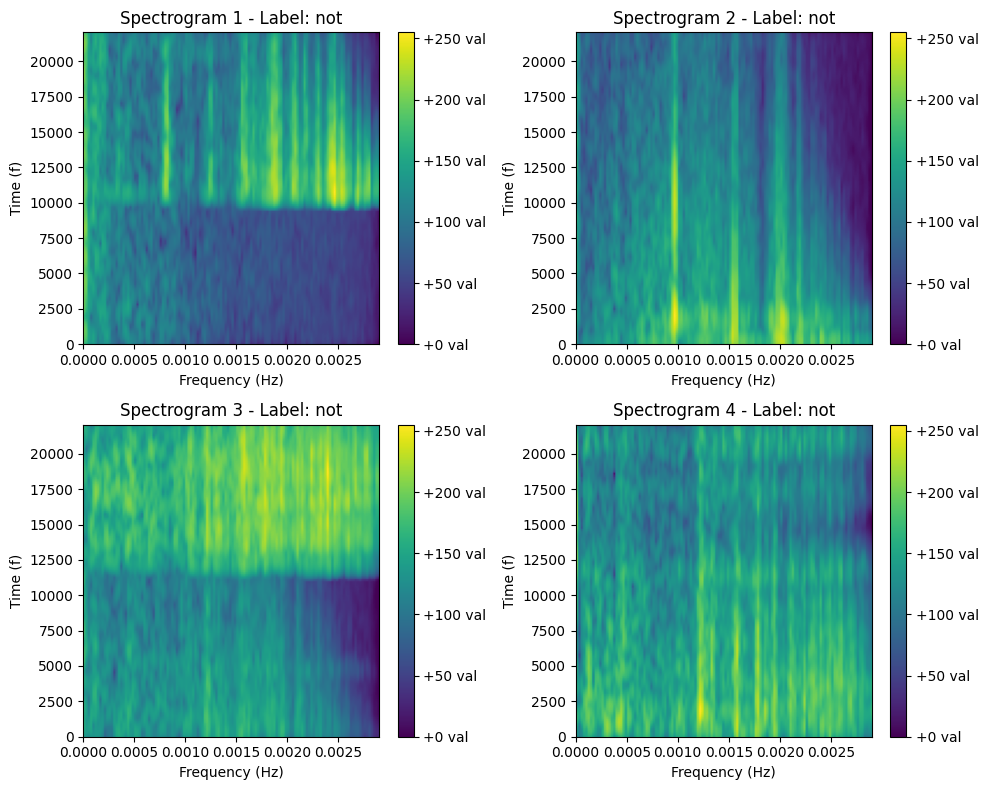

In [56]:
selected_rows = dataset_df_scaled.sample(n=4)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the subplots and fill each with a spectrogram
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    spectrogram = row['features']
    label = row['class_label']
    ax = axs[i // 2, i % 2]  # Calculate the subplot position
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, spectrogram.shape[1] / SAMPLE_RATE, 0, SAMPLE_RATE / 2])
    ax.set_title(f'Spectrogram {i+1} - Label: {idx2label(label, oh_encoder)}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (f)')
    fig.colorbar(im, ax=ax, format='%+2.0f val')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

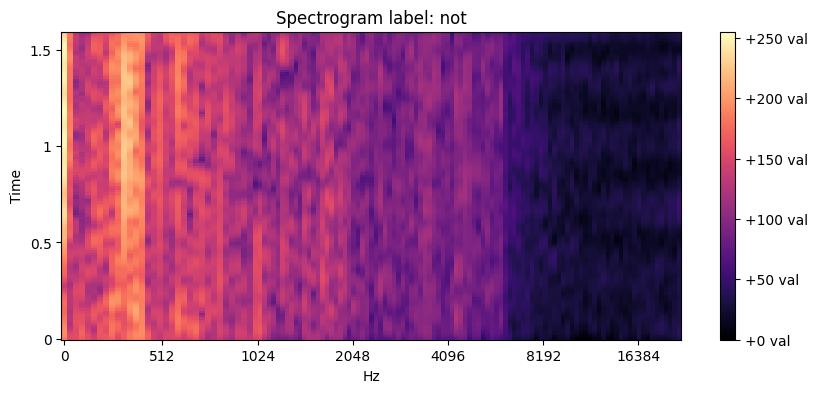

In [57]:
# Get the random feature array
sample_no = 3
sample_f = dataset_df_scaled.iloc[sample_no]["features"]
sample_l = dataset_df_scaled.iloc[sample_no]["class_label"]
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_f, sr=SAMPLE_RATE, x_axis='mel', y_axis='time')
plt.colorbar(format='%+2.0f val')
plt.title('Spectrogram label: ' + idx2label(sample_l, oh_encoder))
plt.show()

In [58]:
# Augemtnation dataset
"""
def augment_image(image, label):
    # Randomly adjust the brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Randomly adjust the contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Time masking
    time_mask_param = tf.random.uniform([], maxval=image.shape[1], dtype=tf.int32)
    image = tf.image.random_crop(image, [image.shape[0], time_mask_param, image.shape[2]])
    
    # Frequency masking
    freq_mask_param = tf.random.uniform([], maxval=image.shape[0], dtype=tf.int32)
    image = tf.image.random_crop(image, [freq_mask_param, image.shape[1], image.shape[2]])
    
    # Resize back to original shape
    image = tf.image.resize(image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
    
    return image, label

# Create TensorFlow datasets
train_dataset_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset_aug = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply data augmentation to the training dataset
train_dataset_aug = train_dataset_aug.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_aug = train_dataset_aug.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset_aug = val_dataset_aug.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
"""

'\ndef augment_image(image, label):\n    # Randomly adjust the brightness\n    image = tf.image.random_brightness(image, max_delta=0.1)\n    \n    # Randomly adjust the contrast\n    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)\n    \n    # Time masking\n    time_mask_param = tf.random.uniform([], maxval=image.shape[1], dtype=tf.int32)\n    image = tf.image.random_crop(image, [image.shape[0], time_mask_param, image.shape[2]])\n    \n    # Frequency masking\n    freq_mask_param = tf.random.uniform([], maxval=image.shape[0], dtype=tf.int32)\n    image = tf.image.random_crop(image, [freq_mask_param, image.shape[1], image.shape[2]])\n    \n    # Resize back to original shape\n    image = tf.image.resize(image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])\n    \n    return image, label\n\n# Create TensorFlow datasets\ntrain_dataset_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))\nval_dataset_aug = tf.data.Dataset.from_tensor_slices((x_test, y_test))\n\n# Apply data augmen

## 3.3 Reshape sets for NN input layer

In [59]:
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[])
#x_test = x_test.reshape((x_test.shape[0],) + INPUT_SHAPE)

num_labels = y.shape[1]
print(f"num_labels: {num_labels}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

num_labels: 3
x_train shape: (9380, 138, 128, 1)
y_train shape: (9380, 3)


# 4. Build Deep Learning Model

## 4.1 Load deep neural net

In [60]:
# load a class with various model archietectures to test
modelClass = Deep_NN(num_classes=num_labels, input_shape=INPUT_SHAPE)

In [61]:
# Choose model architecture to train on
# MODEL_ARCH = customCNN1 mobilenetv3_nn convnext_nn effnetv2_nn dense_nn
# MODEL_TYPE = small large tiny base (optional)
#MODEL_ARCH = "dense_nn"
#MODEL_TYPE = "small"

model = getattr(modelClass, MODEL_ARCH)(type=MODEL_TYPE)

Active Neural Net: 'SmallerVGGNet' default, 
 Input Shape: (138, 128, 1) 
 Num Classes: 3 



## 4.2 Compile Sequential Model

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [63]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=optimizer, 
    loss='CategoricalCrossentropy', 
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')],
    )

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 138, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 42, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 42, 64)       2

### Introduce Callbacks and Augmentations if necessary

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)


In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation transformations
datagen = ImageDataGenerator(
    width_shift_range=0.08,
    height_shift_range=0.08,
    fill_mode='nearest',
)

# Assuming x_train and y_train are your training data and labels
train_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
validation_generator = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=True)


## 4.3 Fit Model, View Loss and KPI Plots

In [67]:
if AUGMENTATION:
    
    hist = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=validation_generator, 
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    validation_steps=len(x_test) // BATCH_SIZE,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    callbacks=[model_checkpoint],
                    verbose=1)

else:
             
    hist = model.fit(x_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    callbacks=[model_checkpoint],
                    verbose=1)


Epoch 1/25
293/293 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.9079 - precision: 0.9128 - recall: 0.9043
Epoch 1: val_loss improved from inf to 0.21583, saving model to e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 230s 779ms/step - loss: 0.2979 - accuracy: 0.9079 - precision: 0.9128 - recall: 0.9043 - val_loss: 0.2158 - val_accuracy: 0.9508 - val_precision: 0.9516 - val_recall: 0.9508
Epoch 2/25
293/293 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9636 - precision: 0.9651 - recall: 0.9619
Epoch 2: val_loss improved from 0.21583 to 0.18925, saving model to e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 265s 907ms/step - loss: 0.1071 - accuracy: 0.9636 - precision: 0.9651 - recall: 0.9619 - val_loss: 0.1893 - val_accuracy: 0.9354 - val_precision: 0.9361 - val_recall: 0.9341
Epoch 3/25
293/293 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9723 - precision: 0.9733 - recall: 0.9708
Epoch 3: val_loss improved from 0.18925 to 0.15004, saving model to e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 248s 846ms/step - loss: 0.0885 - accuracy: 0.9723 - precision: 0.9733 - recall: 0.9708 - val_loss: 0.1500 - val_accuracy: 0.9551 - val_precision: 0.9571 - val_recall: 0.9542
Epoch 4/25
293/293 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9790 - precision: 0.9795 - recall: 0.9783
Epoch 4: val_loss improved from 0.15004 to 0.03482, saving model to e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 264s 902ms/step - loss: 0.0647 - accuracy: 0.9790 - precision: 0.9795 - recall: 0.9783 - val_loss: 0.0348 - val_accuracy: 0.9893 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 5/25
293/293 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9825 - precision: 0.9835 - recall: 0.9821
Epoch 5: val_loss did not improve from 0.03482
293/293 [==============================] - 248s 847ms/step - loss: 0.0501 - accuracy: 0.9825 - precision: 0.9835 - recall: 0.9821 - val_loss: 0.0809 - val_accuracy: 0.9705 - val_precision: 0.9717 - val_recall: 0.9692
Epoch 6/25
293/293 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9753 - precision: 0.9764 - recall: 0.9742
Epoch 6: val_loss did not improve from 0.03482
293/293 [==============================] - 313s 1s/step - loss: 0.0749 - accuracy: 0.9753 - precision: 0.9764 - recall: 0.9742 - val_loss: 1.2024 - val_accuracy: 0.8086 - val_precision: 0.8090 - val_recall:

INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 211s 721ms/step - loss: 0.0328 - accuracy: 0.9889 - precision: 0.9892 - recall: 0.9889 - val_loss: 0.0159 - val_accuracy: 0.9927 - val_precision: 0.9931 - val_recall: 0.9927
Epoch 14/25
293/293 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9906 - precision: 0.9907 - recall: 0.9906
Epoch 14: val_loss did not improve from 0.01588
293/293 [==============================] - 234s 798ms/step - loss: 0.0271 - accuracy: 0.9906 - precision: 0.9907 - recall: 0.9906 - val_loss: 0.0311 - val_accuracy: 0.9914 - val_precision: 0.9914 - val_recall: 0.9906
Epoch 15/25
293/293 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9905 - precision: 0.9909 - recall: 0.9905
Epoch 15: val_loss improved from 0.01588 to 0.01391, saving model to e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 245s 835ms/step - loss: 0.0297 - accuracy: 0.9905 - precision: 0.9909 - recall: 0.9905 - val_loss: 0.0139 - val_accuracy: 0.9966 - val_precision: 0.9966 - val_recall: 0.9966
Epoch 16/25
293/293 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9841 - precision: 0.9844 - recall: 0.9837
Epoch 16: val_loss did not improve from 0.01391
293/293 [==============================] - 240s 819ms/step - loss: 0.0519 - accuracy: 0.9841 - precision: 0.9844 - recall: 0.9837 - val_loss: 0.0880 - val_accuracy: 0.9713 - val_precision: 0.9713 - val_recall: 0.9713
Epoch 17/25
293/293 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9880 - precision: 0.9882 - recall: 0.9879
Epoch 17: val_loss did not improve from 0.01391
293/293 [==============================] - 233s 796ms/step - loss: 0.0374 - accuracy: 0.9880 - precision: 0.9882 - recall: 0.9879 - val_loss: 0.0140 - val_accuracy: 0.9932 - val_precision: 0.9932 - val_

INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


INFO:tensorflow:Assets written to: e:\User\majoron\Python\project\Audio-Classify-2\MODEL\19_PNY_299-MODEL-SmallerVGGNet-default-mel\assets


293/293 [==============================] - 254s 866ms/step - loss: 0.0343 - accuracy: 0.9884 - precision: 0.9887 - recall: 0.9883 - val_loss: 0.0137 - val_accuracy: 0.9953 - val_precision: 0.9953 - val_recall: 0.9953
Epoch 21/25
293/293 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9804 - precision: 0.9806 - recall: 0.9803
Epoch 21: val_loss did not improve from 0.01367
293/293 [==============================] - 267s 913ms/step - loss: 0.0662 - accuracy: 0.9804 - precision: 0.9806 - recall: 0.9803 - val_loss: 0.9350 - val_accuracy: 0.8643 - val_precision: 0.8646 - val_recall: 0.8639
Epoch 22/25
293/293 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9841 - precision: 0.9846 - recall: 0.9836
Epoch 22: val_loss did not improve from 0.01367
293/293 [==============================] - 214s 729ms/step - loss: 0.0531 - accuracy: 0.9841 - precision: 0.9846 - recall: 0.9836 - val_loss: 0.0428 - val_accuracy: 0.9863 - val_precision: 0.9880 - val_

Best Training Loss: 0.0271 at epoch 13
Best Validation Loss: 0.0137 at epoch 19


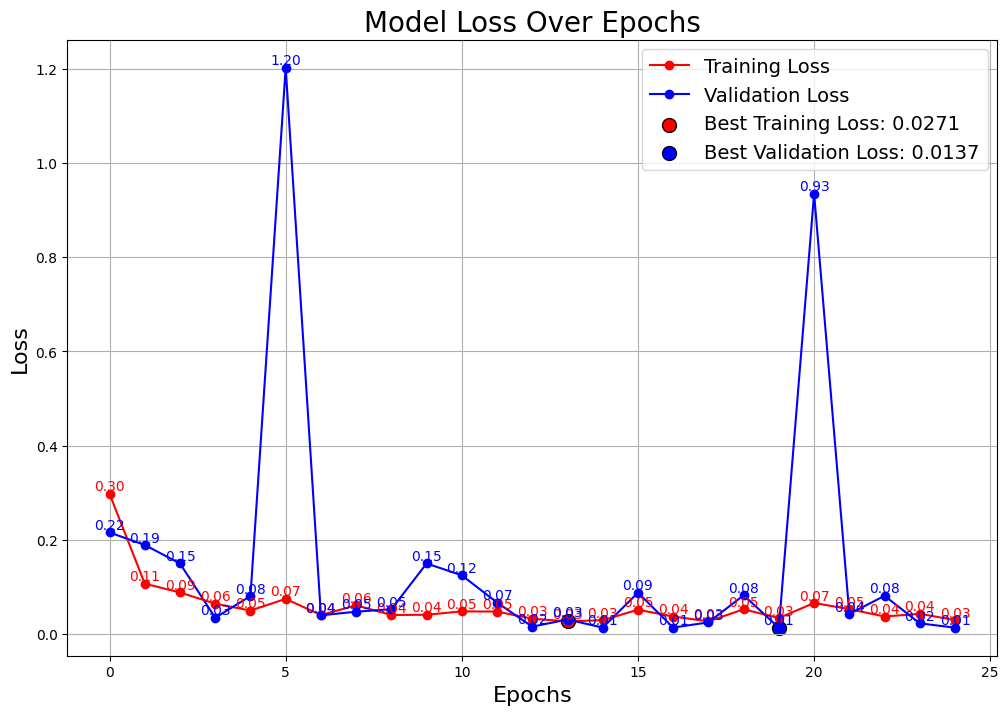

In [68]:
# Find the minimum training and validation losses and their corresponding epochs
min_train_loss = min(hist.history['loss'])
min_val_loss = min(hist.history['val_loss'])
min_train_epoch = hist.history['loss'].index(min_train_loss)
min_val_epoch = hist.history['val_loss'].index(min_val_loss)

# Print the best losses and corresponding epochs
print(f'Best Training Loss: {min_train_loss:.4f} at epoch {min_train_epoch}')
print(f'Best Validation Loss: {min_val_loss:.4f} at epoch {min_val_epoch}')

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(hist.history['loss'], 'r-', marker='o', label='Training Loss')
plt.plot(hist.history['val_loss'], 'b-', marker='o', label='Validation Loss')

# Highlight the points of minimum loss
plt.scatter(min_train_epoch, min_train_loss, color='red', s=100, edgecolors='k', label=f'Best Training Loss: {min_train_loss:.4f}')
plt.scatter(min_val_epoch, min_val_loss, color='blue', s=100, edgecolors='k', label=f'Best Validation Loss: {min_val_loss:.4f}')

# Title and labels with additional context
plt.title('Model Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid(True)

# Add numerical annotations for all points
for i, (train_loss, val_loss) in enumerate(zip(hist.history['loss'], hist.history['val_loss'])):
    plt.text(i, train_loss, f'{train_loss:.2f}', ha='center', va='bottom', color='red', fontsize=10)
    plt.text(i, val_loss, f'{val_loss:.2f}', ha='center', va='bottom', color='blue', fontsize=10)

# Add legend
plt.legend(loc='best', fontsize=14)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.savefig(os.path.join(PLOTS_DIR, f'{NEW_MODEL_NAME}-lossPlot-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png'))
plt.show()

Best Training Accuracy: 0.9918 at epoch 24
Best Validation Accuracy: 0.9966 at epoch 14


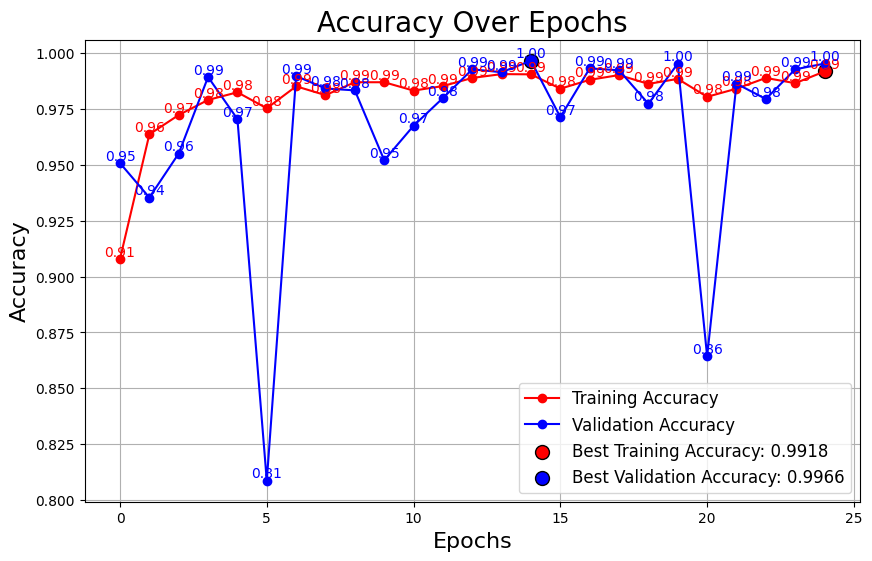

In [69]:
# Find the maximum training and validation accuracies and their corresponding epochs
max_train_acc = max(hist.history['accuracy'])
max_val_acc = max(hist.history['val_accuracy'])
max_train_epoch = hist.history['accuracy'].index(max_train_acc)
max_val_epoch = hist.history['val_accuracy'].index(max_val_acc)

# Print the best accuracies and corresponding epochs
print(f'Best Training Accuracy: {max_train_acc:.4f} at epoch {max_train_epoch}')
print(f'Best Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_epoch}')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], 'r-', marker='o', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', marker='o', label='Validation Accuracy')

# Highlight the points of maximum accuracy
plt.scatter(max_train_epoch, max_train_acc, color='red', s=100, edgecolors='k', label=f'Best Training Accuracy: {max_train_acc:.4f}')
plt.scatter(max_val_epoch, max_val_acc, color='blue', s=100, edgecolors='k', label=f'Best Validation Accuracy: {max_val_acc:.4f}')

# Title and labels with additional context
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True)

# Add numerical annotations for all points
for i, (train_acc, val_acc) in enumerate(zip(hist.history['accuracy'], hist.history['val_accuracy'])):
    plt.text(i, train_acc, f'{train_acc:.2f}', ha='center', va='bottom', color='red')
    plt.text(i, val_acc, f'{val_acc:.2f}', ha='center', va='bottom', color='blue')

# Add legend
plt.legend(loc='best', fontsize=12)

plt.savefig(os.path.join(PLOTS_DIR, f'{NEW_MODEL_NAME}-accuracyPlot-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png'))
plt.show()

Best Training Precision: 0.9921 at epoch 24
Best Validation Precision: 0.9966 at epoch 14


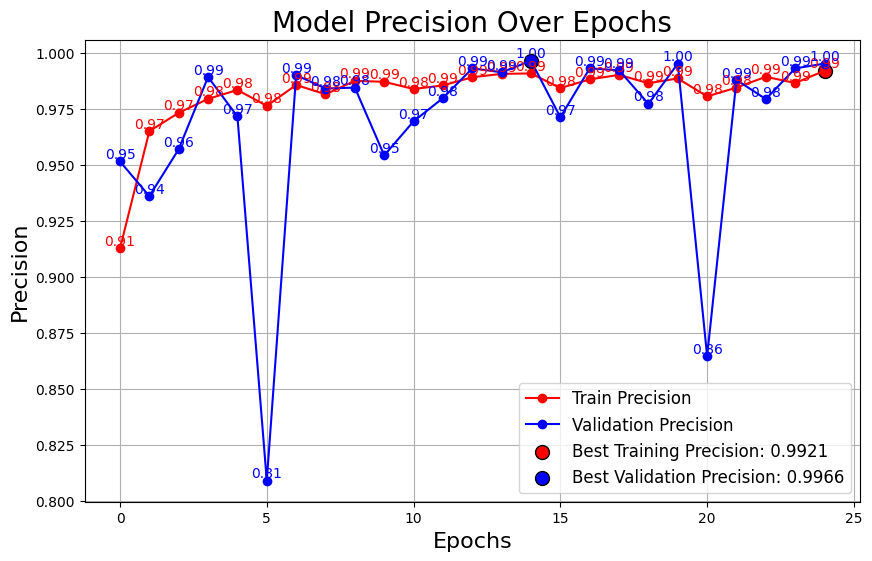

In [70]:
# Find the maximum training and validation precisions and their corresponding epochs
max_train_prec = max(hist.history['precision'])
max_val_prec = max(hist.history['val_precision'])
max_train_epoch = hist.history['precision'].index(max_train_prec)
max_val_epoch = hist.history['val_precision'].index(max_val_prec)

# Print the best precisions and corresponding epochs
print(f'Best Training Precision: {max_train_prec:.4f} at epoch {max_train_epoch}')
print(f'Best Validation Precision: {max_val_prec:.4f} at epoch {max_val_epoch}')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hist.history['precision'], 'r-', marker='o', label='Train Precision')
plt.plot(hist.history['val_precision'], 'b-', marker='o', label='Validation Precision')

# Highlight the points of maximum precision
plt.scatter(max_train_epoch, max_train_prec, color='red', s=100, edgecolors='k', label=f'Best Training Precision: {max_train_prec:.4f}')
plt.scatter(max_val_epoch, max_val_prec, color='blue', s=100, edgecolors='k', label=f'Best Validation Precision: {max_val_prec:.4f}')

# Title and labels with additional context
plt.title('Model Precision Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.grid(True)

# Add numerical annotations for all points
for i, (train_prec, val_prec) in enumerate(zip(hist.history['precision'], hist.history['val_precision'])):
    plt.text(i, train_prec, f'{train_prec:.2f}', ha='center', va='bottom', color='red')
    plt.text(i, val_prec, f'{val_prec:.2f}', ha='center', va='bottom', color='blue')

# Add legend
plt.legend(loc='best', fontsize=12)

plt.show()

# 5. Taining Evaluation

## 5.1 Make a Prediction, Plot performance

In [71]:
predictions = model.predict(x_test)

74/74 [==============================] - 11s 146ms/step


In [72]:
print(idx2label(predictions[19], oh_encoder))
print(idx2label(y_test[19], oh_encoder))
print(f"input default shape: {x_test[1].shape}")
print(f"reshaped input feature shape: {np.expand_dims((x_test[21]), axis=0).shape}")

wine
wine
input default shape: (138, 128, 1)
reshaped input feature shape: (1, 138, 128, 1)


In [73]:
prediction = model.predict(np.expand_dims((x_test[1]), axis=0))
print(prediction)
print(idx2label(prediction, oh_encoder))

1/1 [==============================] - 0s 36ms/step
[[1.4612081e-10 1.0000000e+00 5.4415104e-09]]
whiskey


In [74]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

294/294 [==============================] - 47s 157ms/step - loss: 0.0057 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981
Training Accuracy:  0.9980810284614563
74/74 [==============================] - 11s 144ms/step - loss: 0.0144 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945
Testing Accuracy:  0.9944586753845215


74/74 [==============================] - 11s 144ms/step - loss: 0.0144 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945


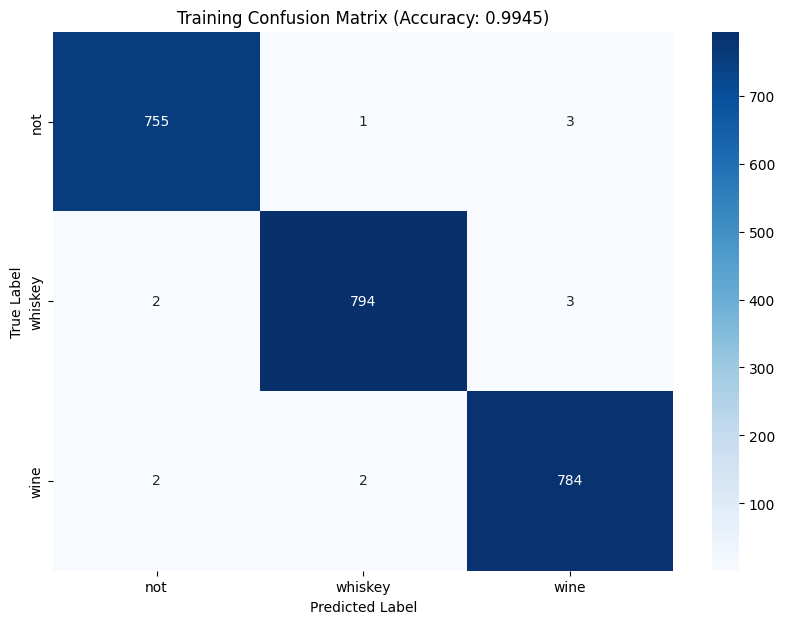

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Assuming 'predictions' is an array of predicted probabilities for each class
# And 'y_test' is an array of actual class labels

# Convert predicted probabilities to class labels
predicted_labels = [idx2label(pred, oh_encoder) for pred in predictions]
y_test_labels = [idx2label(pred, oh_encoder) for pred in y_test]

# Use LabelEncoder to handle class names
label_encoder = LabelEncoder()
label_encoder.fit(y_test_labels + predicted_labels)  # Fit encoder on both true and predicted labels

# Transform labels to numeric values
y_test_numeric = label_encoder.transform(y_test_labels)
predictions_numeric = label_encoder.transform(predicted_labels)

# Create the confusion matrix with real label names
cm = confusion_matrix(y_test_numeric, predictions_numeric)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

score = model.evaluate(x_test, y_test, verbose=1)
plt.title(f"Training Confusion Matrix (Accuracy: {score[1]:.4f})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig(os.path.join(PLOTS_DIR, f"{NEW_MODEL_NAME}-TEST-confusion_matrix-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png"))

plt.show()

## 5.2 Save Model

In [76]:
model.save(f"{MODEL_PATH}.{MODEL_FORMAT}", save_format = MODEL_FORMAT)
joblib.dump(oh_encoder, LABELER_PATH)

['e:\\User\\majoron\\Python\\project\\Audio-Classify-2\\MODEL\\19_PNY_299-ENCODER-SmallerVGGNet-default-mel.joblib']

## 5.3 Save for TF-lite

In [77]:
if LITE_VERSION:
    model.save(MODEL_PATH, save_format='tf')

    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: apply optimizations for quantization
    tflite_model = converter.convert()
    with open(LITE_MODEL_PATH, 'wb') as f:
        f.write(tflite_model)

In [78]:
import json
config = {
        "audio_chunk": AUDIO_CHUNK,
        "data_range": DATA_RANGE,
        "num_channels": NUM_CHANNELS,
        "sample_rate": SAMPLE_RATE,

        "num_mels": N_MELS,
        "n_fft": NFFT,
        "hop_length": HOP_LENGTH,
        "n_frames": N_FRAMES,
        "n_mfcc": N_MFCC,
        "fmax": FMAX,

        "main_feature": MAIN_FEATURE,
        "labels": LABELS,
        
        "model_path": MODEL_PATH,
        "model_format": MODEL_FORMAT,
        "lite_model_path": LITE_MODEL_PATH,
        "labeler_path": LABELER_PATH,
        "scaler_type": "fitted",
        "scaler_path": SCALER_PATH,
        "config_path": CONFIG_PATH,

    }

with open(CONFIG_PATH, 'w') as config_file:
    json.dump(config, config_file, indent=4)

# 6. Inference 

### Load local model and labels

In [79]:
# Load config and setup everything from the config file for inference:
with open(CONFIG_PATH, 'r') as config_file:
    config = json.load(config_file)

loaded_encoder = joblib.load(config["labeler_path"])
scaler = joblib.load(config["scaler_path"])
model = tf.keras.models.load_model(f"{config['model_path']}.{config['model_format']}")

audio_processor = AudioProcessor(
    sample_rate=config["sample_rate"],
    n_mels=config["num_mels"],
    n_mfcc=config["n_mfcc"],
    fmax=config["fmax"],
    n_fft=config["n_fft"],
    hop_length=config["hop_length"],
    audio_chunk=config["audio_chunk"],
    data_range=config["data_range"],
    main_feature=config["main_feature"],
    scaler_type=config["scaler_type"],
    scaler_path=config["scaler_path"],
    use_delta=False,
    slice_audio=False,
)

## 6.1 Inference on local files and loaded model

### 6.1.1 Confusion Matrix for TEST_DIR

Only 1357 files available. Testing all available files.
1/1 [==============================] - 0s 33ms/step


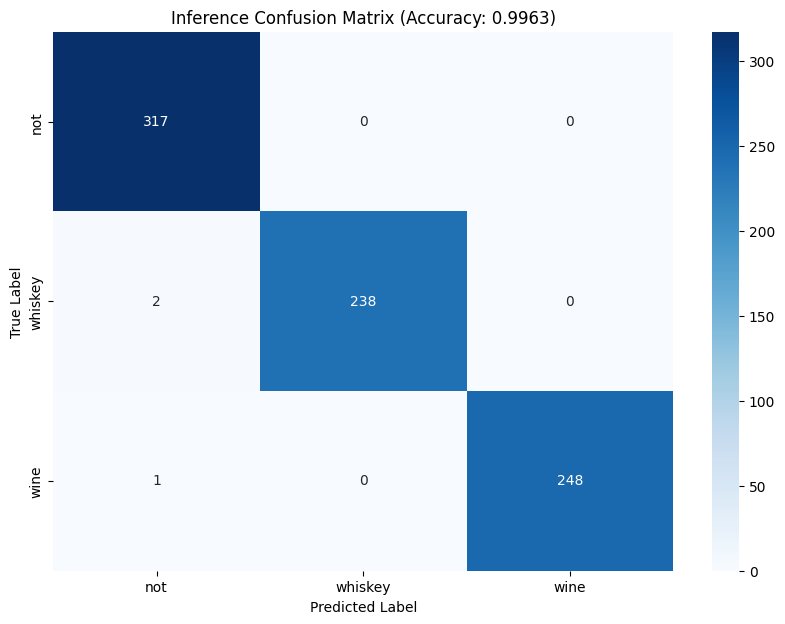

In [80]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import librosa
from sklearn.preprocessing import LabelEncoder

# Set constants
NUM_FILES_TO_TEST = 2000  # Specify the number of files to test

# Get all audio files and corresponding labels from the TEST_DIR
audio_files = []
labels = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.endswith(('.wav', '.mp3')):  # Add other audio file extensions if needed
            audio_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Ensure there are files to process
if not audio_files:
    print("No files in test directory")
    exit()

# Shuffle and select a subset of files
if len(audio_files) < NUM_FILES_TO_TEST:
    print(f"Only {len(audio_files)} files available. Testing all available files.")
    selected_files = audio_files
    selected_labels = labels
else:
    selected_indices = random.sample(range(len(audio_files)), NUM_FILES_TO_TEST)
    selected_files = [audio_files[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]

# Filter out labels not present in the encoder
encoder_classes = set(loaded_encoder.categories_[0])
filtered_files_labels = [(file, label) for file, label in zip(selected_files, selected_labels) if label in encoder_classes]

if not filtered_files_labels:
    print("No valid labels in selected files")
    exit()

selected_files, selected_labels = zip(*filtered_files_labels)

# Process all files and collect predictions and true labels
predictions = []
y_test_labels = []
for file, label in zip(selected_files, selected_labels):
    data, _ = librosa.load(file, sr=SAMPLE_RATE)
    prediction_feature = audio_processor(data=data)
    prediction_feature = np.expand_dims(prediction_feature, axis=0)
    prediction_feature = np.expand_dims(prediction_feature, axis=-1)
    predicted_class = model.predict(prediction_feature)
    predicted_label = idx2label(predicted_class, loaded_encoder)
    
    predictions.append(predicted_label)
    y_test_labels.append(label)

# Use LabelEncoder for label transformation
label_encoder = LabelEncoder()
label_encoder.fit(list(encoder_classes))  # Fit encoder on known classes

# Transform labels to numeric values
y_test_numeric = label_encoder.transform(y_test_labels)
predictions_numeric = label_encoder.transform(predictions)

# Create the confusion matrix with real label names
cm = confusion_matrix(y_test_numeric, predictions_numeric)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

accuracy = np.mean([1 if p == t else 0 for p, t in zip(predictions, y_test_labels)])
plt.title(f"Inference Confusion Matrix (Accuracy: {accuracy:.4f})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the figure
plt.savefig(os.path.join(PLOTS_DIR, f"{NEW_MODEL_NAME}-INFERENCE-confusion_matrix-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png"))

# Show the plot
plt.show()

# Find incorrect predictions
incorrect_indices = [i for i, (p, t) in enumerate(zip(predictions, y_test_labels)) if p != t]
incorrect_files = [selected_files[i] for i in incorrect_indices]
incorrect_labels = [y_test_labels[i] for i in incorrect_indices]


### 6.1.2 Closer Inspection with Listen

In [81]:
import time
from IPython.display import Audio, display

# This test takes audio samples from the cell before, if cell before is run.py
# That variable below does not have any effect, unless you skip the cell above.
NUM_FILES_TO_TEST = 25  # Specify the number of files to test
RETURN_INCORRECT = True  # Return only incorrectly predicted ones?

# Check if 'incorrect_files' and 'incorrect_labels' are available from the confusion matrix cell
try:
    incorrect_files
    incorrect_labels
    if RETURN_INCORRECT:
        print("Using only incorrectly predicted files from the confusion matrix cell.")
    else:
        raise NameError("Returning all files.")
except NameError:
    # If not available, proceed with random selection
    audio_files = []
    labels = []
    for root, _, files in os.walk(TEST_DIR):
        for file in files:
            if file.endswith(('.wav', '.mp3')):  # Add other audio file extensions if needed
                audio_files.append(os.path.join(root, file))
                labels.append(os.path.basename(root))

    if len(audio_files) < NUM_FILES_TO_TEST:
        print(f"Only {len(audio_files)} files available. Testing all available files.")
        selected_files = audio_files
        selected_labels = labels
    else:
        selected_indices = random.sample(range(len(audio_files)), NUM_FILES_TO_TEST)
        selected_files = [audio_files[i] for i in selected_indices]
        selected_labels = [labels[i] for i in selected_indices]
    print("Randomly selected new files for testing.")

# Ensure there are files to process
if not incorrect_files:
    print("No incorrect files to process")
    exit()

# Process and predict each incorrect file, then play the audio and display the prediction
for file, label in zip(incorrect_files, incorrect_labels):
    path = file
    print("Playing file:", os.path.basename(file))
    
    data, _ = librosa.load(path, sr=SAMPLE_RATE)
    
    prediction_feature = audio_processor(data=data)
    prediction_feature = np.expand_dims(prediction_feature, axis=0)
    prediction_feature = np.expand_dims(prediction_feature, axis=-1)
    
    predicted_class = model.predict(prediction_feature)
    predicted_label = idx2label(predicted_class, loaded_encoder)
    print("True label:", label)
    print("Predicted label:", predicted_label)
    
    # Play the audio
    display(Audio(data, rate=SAMPLE_RATE))
    
    time.sleep(1)


Using only incorrectly predicted files from the confusion matrix cell.
Playing file: Whiskey_smallRoom_0015.wav
1/1 [==============================] - 0s 31ms/step
True label: whiskey
Predicted label: not


Playing file: Whiskey_smallRoom_0024.wav
1/1 [==============================] - 0s 32ms/step
True label: whiskey
Predicted label: not


Playing file: Wine_smallRoom_0013.wav
1/1 [==============================] - 0s 30ms/step
True label: wine
Predicted label: not
